Importing libraries and definition of download functions

In [1]:
import requests
import glob
import time
from datetime import datetime as dt
import pandas as pd
import os
import logging
import matplotlib.pyplot as plt
import re
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from PIL import Image
import matplotlib.pyplot as plt
from wordcloud import WordCloud
logging.basicConfig(filename='twitter_tweets.log', filemode='a', format='%(asctime)s - %(message)s - %(name)s - %(levelname)s', level=logging.INFO)
def bearer_oauth(r):
    bearer_token=''#bearer token
    r.headers["Authorization"] = f"Bearer {bearer_token}"
    r.headers["User-Agent"] = "v2FullArchiveSearchPython"
    return r
def download(df,next_page=None): #tweets download function
    keywords='(umweltschutz OR nachhaltigkeit OR Abfallwirtschaft OR abfallentsorgung OR sustainability OR ESG OR umwelt OR nachhaltig OR nachhaltiger OR erneubar\
    OR erneubar OR klimawandel OR klima OR sdg)'#
    fields='author_id,public_metrics,created_at'
    params = {'query': f'{keywords} lang:de', 'max_results':500, 'tweet.fields':fields, 'start_time':'2022-04-15T15:50:36.000Z'}
    search_url = "https://api.twitter.com/2/tweets/search/all"
    if next_page!=None:
        params = {'query': f'{keywords} lang:de', 'max_results':500, 'tweet.fields':fields, 'start_time':'2022-04-15T15:50:36.000Z'}
    else:
        params = {'query': f'{keywords} lang:de', 'max_results':500, 'tweet.fields':fields, 'start_time':'2022-04-15T15:50:36.000Z','pagination_token': next_page}
    while True:
        response = requests.request("GET", search_url, auth=bearer_oauth, params=params )
        if response.status_code != 200:
            logging.error(f'download failed   with status code {response.status_code}\n{response.text}')
            if response.status_code==429:
                wait_time=int(response.headers['x-rate-limit-reset'])-round(dt.now().timestamp())+2
                reset_time=response.headers['x-rate-limit-reset']
                logging.error(f'Status code is 429, sleeping for {wait_time} seconds until {reset_time}')
                time.sleep(wait_time)
                continue
            time.sleep(50)
            continue
        else:break
    
    df=pd.concat([df,pd.DataFrame(response.json()['data'])])
    try:
        next_token=response.json()['meta']['next_token']
        time.sleep(20)
        df.to_csv(f'main_tweets.csv')
        logging.info(f'continuing download of tweets, next page token {next_token}')
        return download(df, next_page=next_token)
    except KeyError:
        df.to_csv(f'main_tweets.csv')
        return df

def download(df,acc_id,next_page=None):#followers download
    def bearer_oauth(r):
        bearer_token=''
        r.headers["Authorization"] = f"Bearer {bearer_token}"
        r.headers["User-Agent"] = "v2FullArchiveSearchPython"
        return r
    if next_page!=None:
        params = {'max_results': '1000','pagination_token': next_page}
    else:
        params = {'max_results': '1000','pagination_token': next_page}
    search_url = f"https://api.twitter.com/2/users/{acc_id}/followers"
    while True:
        response = requests.request("GET", search_url, auth=bearer_oauth, params=params )
        if response.status_code != 200:
            logging.error(f'download failed for acc_id {acc_id} with status code {response.status_code}\n{response.text}')
            if response.status_code==429:
                wait_time=int(response.headers['x-rate-limit-reset'])-round(dt.now().timestamp())+2
                reset_time=response.headers['x-rate-limit-reset']
                logging.error(f'Status code is 429, sleeping for {wait_time} seconds until {reset_time}')
                time.sleep(wait_time)
                continue
            time.sleep(50)
            continue
        else:break
    
    df=pd.concat([df,pd.DataFrame(response.json()['data']).drop(['name','username'], axis=1)])
    try:
        next_token=response.json()['meta']['next_token']
        time.sleep(20)
        df[acc_id]=1
        df.to_csv(f'tweet_follows/{acc_id}.csv')
        logging.info(f'continuing download of followers from {acc_id} next page token {next_token}')
        return download(df,acc_id, next_page=next_token)
    except KeyError:
        df[acc_id]=1
        df.to_csv(f'tweet_follows/{acc_id}.csv')
        return df
df=pd.DataFrame()




R code to download from parliamentary databases ( resulting frames 'business.csv' and 'sessions.csv')

In [ ]:
swissparl::get_data(
table = "Business", #or 'Transcript'
 SubmissionDate = c(">2021-12-31", "<2022-05-08"), 
 Language = "DE"))

Merging followers with thematic tweets frames

In [ ]:

df=pd.DataFrame()
for x in glob.glob('tweet_follows/*'):#folder where tweet followers of media outlets are stored
    if os.path.basename(x)=='14273050.csv':continue
    df=pd.concat([df,pd.read_csv(x)])
df=pd.DataFrame(df['id'].unique())
bank=pd.read_csv('tweets_bank_CH.csv')
edu=pd.concat([pd.read_csv('tweets_edu_CH.csv'),pd.read_csv('tweets_edu_CH1.csv')]).drop_duplicates('id')
bank=pd.merge(df,bank,left_on=0,right_on='author_id', how='inner')
bank['created_at']=pd.to_datetime(bank['created_at'])
bank['created_at']=bank.apply(lambda x: x['created_at'].to_period('M'),axis=1)
edu=pd.merge(df,edu,left_on=0,right_on='author_id', how='inner')
edu['created_at']=pd.to_datetime(edu['created_at'])
edu['created_at']=edu.apply(lambda x: x['created_at'].to_period('M'),axis=1)
#edu.to_csv('edu_final.csv')
#bank.to_csv('bank_final.csv')



Looking for words in parliamentary texts

In [ ]:
bank_dict='[Bb]ankengesetz|[Pp]fandbriefgesetz|[Kk]ollektivanlagegesetz|[Ff]inanzinstitutgesetz|[Ff]inIA|[Ff]inanzmarktinfrastrukturgesetz|[Ff]inanzdienstleistungsgesetz|[Ff]IDLEG|[Gg]eldwäschereigesetz|[Gg]eldwäscherei|[Ee]igenmittelverordnung|[Ff]INMA|[Ss]ystemrelevante Banken|[Ff]inanzmarktregulierung|[Ll]iquiditätsanforderungen|[Ll]iquiditätsausstattung|[Ll]iquiditätsverordnung|[Ll]iqV|[Tt]oo big to fail|[Bb]CBS|[Bb]asler Ausschuss für Bankenaufsicht|[Bb]ankeninsolvenz|[Vv]erschuldungsquote|[Ll]everage Ratio|[Rr]isikogewichtete Aktiven|[Cc]ET1|[Pp]ufferanforderungen|[Rr]WA|[Rr]isk weighted assets|[Ss]IB|[Kk]asino-Kapitalismus|[Bb]asel III'
edu_dict='[Bb]ildungssystem|[Bb]ildungsrat|[Bb]ildungswesen|[Bb]ildungsausgaben|[Bb]ildungsförderung|[Ss]chulpflicht|[Ss]chulobligatorium|[Ll]ehrplan 21|[Dd]-EDK|[Ee]DK|[Bb]ildungsgesetz|[Ss]chulgesetz|[Gg]rundbildung|[Ss]onderschule|[Pp]ISA-Studie|[Pp]ISA Studie|[Vv]olksschulgesetz|[Bb]ildungsraum|[Ss]chulungsverantwortung|[Bb]ildungspflicht|[Ss]chulmodelle'

def fix_um(strr):
    if type(strr)!=str:return
    strr=strr.replace('<U+00F6>','ö')
    strr=strr.replace('<U+00E4>','ä')
    return strr

edu=pd.read_csv('edu_final.csv')
bank=pd.read_csv('bank_final.csv')
trans=pd.concat([pd.read_csv('2010-2015.csv',encoding_errors='ignore'),pd.read_csv('2016-2022.csv',encoding_errors='ignore')])
trans=pd.concat([trans,pd.read_csv('2016.csv',encoding_errors='ignore')])
busi=pd.read_csv('business.csv',encoding_errors='ignore')
sess=pd.read_csv('sessions.csv',encoding_errors='ignore')
st=set(['Motion', 'Postulat', 'Interpellation','Fragestunde. Frage', 'Dringliche Interpellation','Dringliche Anfrage','Anfrage'])
busi['dummy']=busi.apply(lambda x : 1 if x['BusinessTypeName'] in st else 0, axis=1)
busi=busi[busi['dummy']==1]
busi['SubmittedText']=busi.apply(lambda x:str(x['SubmittedText']),axis=1)
trans['Text']=trans.apply(lambda x:str(x['Text']),axis=1)
busi['SubmittedText']=busi.apply(lambda x: fix_um(x['SubmittedText']),axis=1)
trans['Text']=trans.apply(lambda x: fix_um(x['Text']),axis=1)
busi['edu']=busi.apply(lambda x:1 if re.search(edu_dict,x['SubmittedText'])!=None else 0,axis=1)
busi['bank']=busi.apply(lambda x:1 if re.search(bank_dict,x['SubmittedText'])!=None else 0,axis=1)
trans['edu']=trans.apply(lambda x:1 if re.search(edu_dict,x['Text'])!=None else 0,axis=1)
trans['bank']=trans.apply(lambda x:1 if re.search(bank_dict,x['Text'])!=None else 0,axis=1)

In [94]:
trans[trans['bank']==1]['Text'].to_list()[random.randint(0,len(trans[trans['bank']==1]['Text'].to_list()))]

'<pd_text><p>Herr Bundesrat, ich möchte Ihnen eine Frage stellen, damit Sie Ihre Aussagen zum "Too big to fail" noch etwas genauer ausfhren. Sie mögen sich erinnern: In den Jahren 2002 und 2003 machte die Credit Suisse eine ganz schwierige Zeit durch. Es bestand die Gefahr des Scheiterns. Damals wurde "Too big to fail" nicht diskutiert. Jetzt macht die UBS eine schwierige Zeit durch, und jetzt wird es diskutiert. Können Sie mir erklären, was die Unterschiede sind?</p>\r\n</pd_text>'

Calculating word frequencies

In [35]:
bank_dict='[Bb]ankengesetz|[Pp]fandbriefgesetz|[Kk]ollektivanlagegesetz|[Ff]inanzinstitutgesetz|[Ff]inIA|[Ff]inanzmarktinfrastrukturgesetz|[Ff]inanzdienstleistungsgesetz|[Ff]IDLEG|[Gg]eldwäschereigesetz|[Gg]eldwäscherei|[Ee]igenmittelverordnung|[Ff]INMA|[Ss]ystemrelevante Banken|[Ff]inanzmarktregulierung|[Ll]iquiditätsanforderungen|[Ll]iquiditätsausstattung|[Ll]iquiditätsverordnung|[Ll]iqV|[Tt]oo big to fail|[Bb]CBS|[Bb]asler Ausschuss für Bankenaufsicht|[Bb]ankeninsolvenz|[Vv]erschuldungsquote|[Ll]everage Ratio|[Rr]isikogewichtete Aktiven|[Cc]ET1|[Pp]ufferanforderungen|[Rr]WA|[Rr]isk weighted assets|[Ss]IB|[Kk]asino-Kapitalismus|[Bb]asel III'
edu_dict='[Bb]ildungssystem|[Bb]ildungsrat|[Bb]ildungswesen|[Bb]ildungsausgaben|[Bb]ildungsförderung|[Ss]chulpflicht|[Ss]chulobligatorium|[Ll]ehrplan 21|[Dd]-EDK|[Ee]DK|[Bb]ildungsgesetz|[Ss]chulgesetz|[Gg]rundbildung|[Ss]onderschule|[Pp]ISA-Studie|[Pp]ISA Studie|[Vv]olksschulgesetz|[Bb]ildungsraum|[Ss]chulungsverantwortung|[Bb]ildungspflicht|[Ss]chulmodelle'
edu_corpus=' '.join(busi[busi['edu']==1]['SubmittedText'].to_list()+trans[trans['edu']==1]['Text'].to_list())
bank_corpus=' '.join(busi[busi['bank']==1]['SubmittedText'].to_list()+trans[trans['bank']==1]['Text'].to_list())
par_bank_count=dict()
par_edu_count=dict()
for word in bank_dict.split('|'):
    par_bank_count[word]=len(re.findall(word,bank_corpus))
for word in edu_dict.split('|'):
    par_edu_count[word]=len(re.findall(word,edu_corpus))
par_edu_count1=par_edu_count.copy()
for key in par_edu_count1.keys():
    par_edu_count[key[1]+key[4:]]=par_edu_count[key]
    del par_edu_count[key]
par_edu_count['PISA-Studie']=par_edu_count['PISA-Studie']+par_edu_count['PISA Studie']
del par_edu_count['PISA Studie']
par_bank_count1=par_bank_count.copy()
for key in par_bank_count1.keys():
    par_bank_count[key[1]+key[4:]]=par_bank_count[key]
    del par_bank_count[key]
par_bank_count

{'Bankengesetz': 346,
 'Pfandbriefgesetz': 6,
 'Kollektivanlagegesetz': 1,
 'Finanzinstitutgesetz': 0,
 'FinIA': 0,
 'Finanzmarktinfrastrukturgesetz': 127,
 'Finanzdienstleistungsgesetz': 120,
 'FIDLEG': 24,
 'Geldwäschereigesetz': 509,
 'Geldwäscherei': 1544,
 'Eigenmittelverordnung': 54,
 'FINMA': 641,
 'Systemrelevante Banken': 89,
 'Finanzmarktregulierung': 33,
 'Liquiditätsanforderungen': 9,
 'Liquiditätsausstattung': 0,
 'Liquiditätsverordnung': 3,
 'LiqV': 0,
 'Too big to fail': 776,
 'BCBS': 7,
 'Basler Ausschuss für Bankenaufsicht': 2,
 'Bankeninsolvenz': 38,
 'Verschuldungsquote': 26,
 'Leverage Ratio': 46,
 'Risikogewichtete Aktiven': 0,
 'CET1': 0,
 'Pufferanforderungen': 0,
 'RWA': 156,
 'Risk weighted assets': 0,
 'SIB': 1,
 'Kasino-Kapitalismus': 0,
 'Basel III': 89}

In [95]:
par_edu_count

{'Bildungssystem': 532,
 'Bildungsrat': 1,
 'Bildungswesen': 127,
 'Bildungsausgaben': 48,
 'Bildungsförderung': 21,
 'Schulpflicht': 85,
 'Schulobligatorium': 2,
 'Lehrplan 21': 78,
 'D-EDK': 0,
 'EDK': 184,
 'Bildungsgesetz': 509,
 'Schulgesetz': 66,
 'Grundbildung': 258,
 'Sonderschule': 8,
 'PISA-Studie': 2,
 'Volksschulgesetz': 2,
 'Bildungsraum': 101,
 'Schulungsverantwortung': 0,
 'Bildungspflicht': 34,
 'Schulmodelle': 3}

In [49]:
edu=pd.read_csv('edu_final.csv')
bank=pd.read_csv('bank_final.csv')
bank_dict='[Bb]ankengesetz|[Pp]fandbriefgesetz|[Kk]ollektivanlagegesetz|[Ff]inanzinstitutgesetz|[Ff]inIA|[Ff]inanzmarktinfrastrukturgesetz|[Ff]inanzdienstleistungsgesetz|[Ff]IDLEG|[Gg]eldwäschereigesetz|[Gg]eldwäscherei|[Ee]igenmittelverordnung|[Ff]INMA|[Ss]ystemrelevante Banken|[Ff]inanzmarktregulierung|[Ll]iquiditätsanforderungen|[Ll]iquiditätsausstattung|[Ll]iquiditätsverordnung|[Ll]iqV|[Tt]oo big to fail|[Bb]CBS|[Bb]asler Ausschuss für Bankenaufsicht|[Bb]ankeninsolvenz|[Vv]erschuldungsquote|[Ll]everage Ratio|[Rr]isikogewichtete Aktiven|[Cc]ET1|[Pp]ufferanforderungen|[Rr]WA|[Rr]isk weighted assets|[Ss]IB|[Kk]asino-Kapitalismus|[Bb]asel III'
edu_dict='[Bb]ildungssystem|[Bb]ildungsrat|[Bb]ildungswesen|[Bb]ildungsausgaben|[Bb]ildungsförderung|[Ss]chulpflicht|[Ss]chulobligatorium|[Ll]ehrplan 21|[Dd]-EDK|[Ee]DK|[Bb]ildungsgesetz|[Ss]chulgesetz|[Gg]rundbildung|[Ss]onderschule|[Pp]ISA-Studie|[Pp]ISA Studie|[Vv]olksschulgesetz|[Bb]ildungsraum|[Ss]chulungsverantwortung|[Bb]ildungspflicht|[Ss]chulmodelle'
edu_corpus=' '.join(edu['text'].to_list())
bank_corpus=' '.join(bank['text'].to_list())
tw_bank_count=dict()
tw_edu_count=dict()
for word in bank_dict.split('|'):
    tw_bank_count[word]=len(re.findall(word,bank_corpus))
for word in edu_dict.split('|'):
    tw_edu_count[word]=len(re.findall(word,edu_corpus))
tw_edu_count1=tw_edu_count.copy()
for key in tw_edu_count1.keys():
    tw_edu_count[key[1]+key[4:]]=tw_edu_count[key]
    del tw_edu_count[key]
tw_edu_count['PISA-Studie']=tw_edu_count['PISA-Studie']+tw_edu_count['PISA Studie']
del tw_edu_count['PISA Studie']
tw_bank_count1=tw_bank_count.copy()
for key in tw_bank_count1.keys():
    tw_bank_count[key[1]+key[4:]]=tw_bank_count[key]
    del tw_bank_count[key]
tw_bank_count

{'Bankengesetz': 245,
 'Pfandbriefgesetz': 0,
 'Kollektivanlagegesetz': 6,
 'Finanzinstitutgesetz': 0,
 'FinIA': 0,
 'Finanzmarktinfrastrukturgesetz': 24,
 'Finanzdienstleistungsgesetz': 90,
 'FIDLEG': 516,
 'Geldwäschereigesetz': 340,
 'Geldwäscherei': 4122,
 'Eigenmittelverordnung': 20,
 'FINMA': 3192,
 'Systemrelevante Banken': 138,
 'Finanzmarktregulierung': 428,
 'Liquiditätsanforderungen': 8,
 'Liquiditätsausstattung': 7,
 'Liquiditätsverordnung': 10,
 'LiqV': 1,
 'Too big to fail': 1210,
 'BCBS': 21,
 'Basler Ausschuss für Bankenaufsicht': 4,
 'Bankeninsolvenz': 9,
 'Verschuldungsquote': 73,
 'Leverage Ratio': 77,
 'Risikogewichtete Aktiven': 2,
 'CET1': 12,
 'Pufferanforderungen': 0,
 'RWA': 177,
 'Risk weighted assets': 0,
 'SIB': 335,
 'Kasino-Kapitalismus': 30,
 'Basel III': 702}

Word cloud generation

In [54]:
names=['par_bank_count','par_edu_count','tw_bank_count','tw_edu_count']
for index,count in enumerate([par_bank_count,par_edu_count,tw_bank_count,tw_edu_count]):
    wc = WordCloud(background_color="white",width=1000,height=1000, max_words=20,relative_scaling=0.3,normalize_plurals=False).generate_from_frequencies(count)
    plt.figure(figsize = (10,10))
    plt.axis('off')
    plt.imshow(wc)
    plt.savefig(f'{names[index]}.png', bbox_inches='tight')

par_bank_count


Creation of variables, correlation analysis

In [5]:
busi=pd.read_csv('busi_re.csv',low_memory=False)
trans=pd.read_csv('trans_re.csv',low_memory=False)
sess=pd.read_csv('sessions.csv',encoding_errors='ignore')
sess['StartDate']=pd.to_datetime(sess['StartDate'])
edu=pd.read_csv('edu_final.csv')
edu['created_at']=pd.to_datetime(edu['created_at'])
bank=pd.read_csv('bank_final.csv')
bank['created_at']=pd.to_datetime(bank['created_at'])
bank=bank.groupby('created_at').count()['text']
edu=edu.groupby('created_at').count()['text']
edu=pd.merge(edu,pd.DataFrame(pd.date_range(start='1/1/2010', end='14/05/2022')),left_index=True,right_on=0,how='outer').sort_values(0).set_index(0).fillna(0)
bank=pd.merge(bank,pd.DataFrame(pd.date_range(start='1/1/2010', end='14/05/2022')),left_index=True,right_on=0,how='outer').sort_values(0).set_index(0).fillna(0)
busi=busi.groupby('SubmissionSession').agg({'edu':'sum','bank':'sum'})
trans=trans.groupby('IdSession').agg({'edu':'sum','bank':'sum'})
trans=pd.merge(trans,sess[['ID','StartDate']], left_index=True, right_on='ID', how='left')
busi=pd.merge(busi,sess[['ID','StartDate']], left_index=True, right_on='ID', how='left')
edu=edu.rolling(90,min_periods=1).sum()
bank=bank.rolling(90,min_periods=1).sum()
edu.rename(columns={'text':'tw_edu'},inplace=True)
bank.rename(columns={'text':'tw_bank'},inplace=True)
trans=pd.merge(trans,edu,left_on='StartDate',right_index=True,how='left')
trans=pd.merge(trans,bank,left_on='StartDate',right_index=True,how='left')
busi=pd.merge(busi,edu,left_on='StartDate',right_index=True,how='left')
busi=pd.merge(busi,bank,left_on='StartDate',right_index=True,how='left')
print(pearsonr(trans['edu'].fillna(0),trans['tw_edu'].fillna(0)))
print(pearsonr(trans['bank'].fillna(0),trans['tw_bank'].fillna(0)))
print(pearsonr(busi['edu'].fillna(0),busi['tw_edu'].fillna(0)))
print(pearsonr(busi['bank'].fillna(0),busi['tw_bank'].fillna(0)))

(-0.32463434542276337, 0.01004475460515537)
(-0.28708629786360695, 0.023674564675432573)
(0.09707648083070593, 0.4567151590578962)
(0.110384431876718, 0.39705829968326406)


c:\Users\Startklar\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: UserWarning: Parsing '14/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)
c:\Users\Startklar\AppData\Local\Programs\Python\Python39\lib\site-packages\IPython\core\interactiveshell.py:3444: UserWarning: Parsing '14/05/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


<AxesSubplot:xlabel='StartDate'>

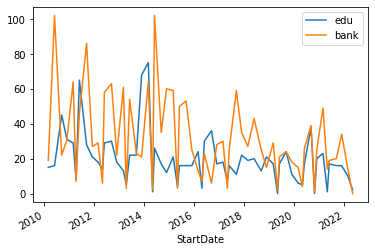

In [15]:
pd.concat([busi,trans]).groupby('StartDate').sum()[['edu','bank']].plot()

In [183]:
busi.describe().T

,count,mean,std,min,25%,50%,75%,max
edu,61.0,3.409836,2.479093,0.0,2.0,3.0,5.0,13.0
bank,61.0,4.655738,3.660079,0.0,2.0,4.0,7.0,17.0
ID,61.0,4974.377049,96.153205,4813.0,4908.0,5003.0,5018.0,5114.0
tw_edu,61.0,806.688525,699.584413,42.0,236.0,532.0,1294.0,3311.0
tw_bank,61.0,418.655738,175.808787,130.0,307.0,388.0,545.0,1101.0


<AxesSubplot:xlabel='created_at'>

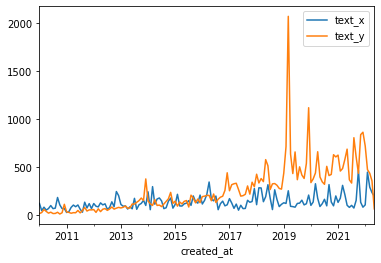

In [140]:
busi=pd.read_csv('busi_re.csv',low_memory=False)
trans=pd.read_csv('trans_re.csv',low_memory=False)
sess=pd.read_csv('sessions.csv',encoding_errors='ignore')
sess['StartDate']=pd.to_datetime(sess['StartDate'])
edu=pd.read_csv('edu_final.csv')
edu['created_at']=pd.to_datetime(edu['created_at'])
bank=pd.read_csv('bank_final.csv')
bank['created_at']=pd.to_datetime(bank['created_at'])
edu['created_at']=edu.apply(lambda x: x['created_at'].to_period('M'),axis=1)
bank['created_at']=bank.apply(lambda x: x['created_at'].to_period('M'),axis=1)
bank=bank.groupby('created_at').count()['text']
edu=edu.groupby('created_at').count()['text']
df=pd.merge(bank,edu,left_index=True,right_index=True)
df.rename(columns={'text_x':'Banking regulation','text_y':'Education'},inplace=True)
df.plot(figsize=(10,10))


In [20]:
#convert to regex
lst='Bildungssystem OR Bildungsrat OR Bildungswesen OR Bildungsausgaben OR Bildungsförderung OR Schulpflicht OR Schulobligatorium OR Lehrplan 21 OR D-EDK OR EDK OR Bildungsgesetz OR Schulgesetz OR Grundbildung OR Sonderschule OR PISA-Studie OR PISA Studie OR Volksschulgesetz OR Bildungsraum OR Schulungsverantwortung OR Bildungspflicht OR Schulmodelle'.split(' OR ')
for i,x in enumerate(lst):
    lst[i]='['+x[0].upper()+x[0].lower()+']'+x[1:]
'|'.join(lst)


'[Bb]ildungssystem|[Bb]ildungsrat|[Bb]ildungswesen|[Bb]ildungsausgaben|[Bb]ildungsförderung|[Ss]chulpflicht|[Ss]chulobligatorium|[Ll]ehrplan 21|[Dd]-EDK|[Ee]DK|[Bb]ildungsgesetz|[Ss]chulgesetz|[Gg]rundbildung|[Ss]onderschule|[Pp]ISA-Studie|[Pp]ISA Studie|[Vv]olksschulgesetz|[Bb]ildungsraum|[Ss]chulungsverantwortung|[Bb]ildungspflicht|[Ss]chulmodelle'